### Function to identify the mask boundary points

In [37]:
import cv2

# Initialize a list to store the coordinates
polygon_vertices = []

def draw_circle(event, x, y, flags, param):
    global polygon_vertices
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Add the point to the list of vertices
        polygon_vertices.append((x, y))
        # Draw a small circle at the point where we clicked
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)
        # Display the image with the points marked
        cv2.imshow('image', img)
        print(f"Point added: {(x, y)}")  # Print the point coordinates

# Load the image
img = cv2.imread('test.png')  # Replace with your image path
cv2.imshow('image', img)

# Set mouse callback function
cv2.setMouseCallback('image', draw_circle)

print("Click on the image to select the vertices of the polygon. Press any key to exit.")

# Wait until a key is pressed
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print out the selected coordinates
print("Selected polygon vertices:")
print(polygon_vertices)


Click on the image to select the vertices of the polygon. Press any key to exit.
Point added: (12, 92)
Point added: (66, 80)
Point added: (99, 90)
Point added: (116, 98)
Point added: (146, 108)
Point added: (163, 117)
Point added: (192, 104)
Point added: (200, 82)
Point added: (204, 64)
Point added: (219, 37)
Point added: (322, 35)
Point added: (392, 29)
Point added: (419, 48)
Point added: (430, 79)
Point added: (445, 117)
Point added: (478, 132)
Point added: (497, 138)
Point added: (503, 148)
Point added: (510, 182)
Point added: (517, 217)
Point added: (518, 250)
Point added: (518, 274)
Point added: (520, 286)
Point added: (572, 373)
Point added: (580, 379)
Point added: (594, 382)
Point added: (611, 377)
Point added: (621, 370)
Point added: (662, 282)
Point added: (672, 258)
Point added: (678, 223)
Point added: (687, 211)
Point added: (705, 190)
Point added: (752, 182)
Point added: (821, 184)
Point added: (886, 258)
Point added: (946, 326)
Point added: (1011, 363)
Point added: (1067, 

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_mask(image_shape, vertices):
    mask = np.ones(image_shape, dtype=np.uint8) * 255  # Create a mask that is all white
    cv2.fillPoly(mask, [np.array(vertices, dtype=np.int32)], 0)  # Fill the polygon with black (0)
    return mask

def preprocess_image(image_path, threshold_value=90, crop_params=None, mask_vertices=None):
    # Load the image
    image_original = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    # Apply a fixed threshold
    _, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Apply mask if vertices are provided
    masked = thresholded.copy()
    if mask_vertices:
        mask = create_mask(gray.shape, mask_vertices)
        # Apply the mask to exclude the polygon area after thresholding
        masked = cv2.bitwise_and(masked, mask)
    
    # Crop the image if crop parameters are provided
    cropped = masked.copy()
    if crop_params:
        cropped = crop_image(masked, *crop_params)
    
    return image_original, gray, thresholded, masked, cropped
    

def crop_image(image, left=0, top=0, right=0, bottom=0):
    height, width = image.shape[:2]
    new_right = width - right
    new_bottom = height - bottom
    cropped_image = image[top:new_bottom, left:new_right]
    return cropped_image


# Function to filter contours based on minimum area
def filter_contours_by_area(contours, min_area=10):
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area]
    return filtered_contours

# Function to find contours and quantify the features
def quantify_features(thresholded, min_area=1):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter_contours_by_area(contours, min_area)
    num_features = len(filtered_contours)
    total_feature_area = sum(cv2.contourArea(cnt) for cnt in filtered_contours)
    return filtered_contours, num_features, total_feature_area

# Function to visualize the results
def visualize_results(original_image, thresholded, filtered_contours, crop_params):
    contour_features_image = original_image.copy()
    crop_offsets = (crop_params[0], crop_params[1])
    # Adjust contours to match the original image's coordinate system
    adjusted_contours = [cnt + np.array([crop_offsets]) for cnt in filtered_contours]
    cv2.drawContours(contour_features_image, adjusted_contours, -1, (0, 255, 0), 2)
    # Convert images to RGB for displaying with matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    threshold_rgb = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
    contour_features_image_rgb = cv2.cvtColor(contour_features_image, cv2.COLOR_BGR2RGB)
    # Display the images
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image_rgb)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Thresholded Binary Image')
    plt.imshow(threshold_rgb)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Detected Features Contours')
    plt.imshow(contour_features_image_rgb)
    plt.axis('off')
    plt.show()

# # Function to crop the image
# def crop_image(image, left=0, top=0, right=0, bottom=0):
#     height, width = image.shape[:2]
#     # Calculate the new edges of the image
#     new_left = left
#     new_top = top
#     new_right = width - right
#     new_bottom = height - bottom
    
#     # Ensure the new edges are within the image boundary
#     new_left = max(0, new_left)
#     new_top = max(0, new_top)
#     new_right = max(new_left, min(width, new_right))  # new_right must be greater than new_left
#     new_bottom = max(new_top, min(height, new_bottom))  # new_bottom must be greater than new_top
    
#     # Crop the image using the new edges
#     cropped_image = image[new_top:new_bottom, new_left:new_right]
#     return cropped_image

### Demonstration

Number of features: 52, Total area of features: 6564.5


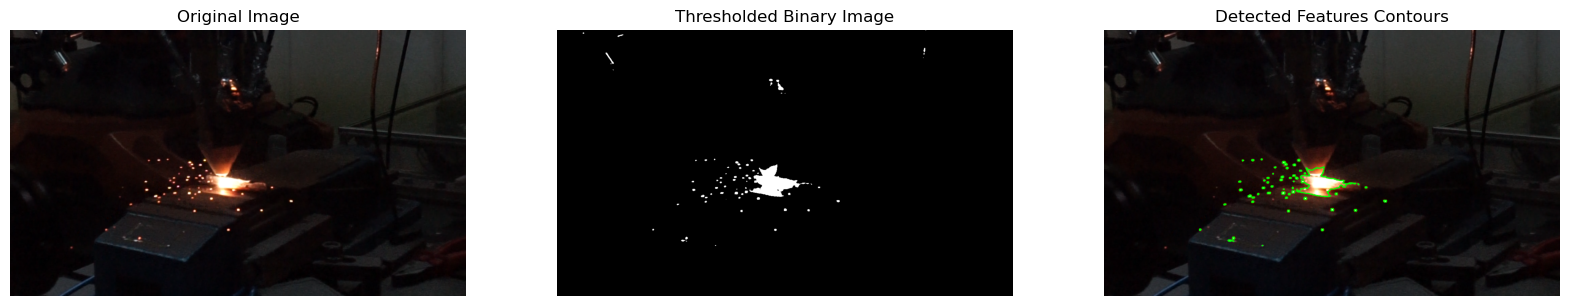

In [38]:
# Main code
image_path = 'test.png'  # Replace with your image path
crop_params = (100, 50, 200, 100)  # Example crop parameters (left, top, right, bottom)

mask_vertices = [(12, 92), (66, 80), (99, 90), (116, 98), (146, 108), (163, 117), (192, 104), (200, 82), (204, 64), (219, 37), (322, 35), (392, 29), (419, 48), (430, 79), (445, 117), (478, 132), (497, 138), (503, 148), (510, 182), (517, 217), (518, 250), (518, 274), (520, 286), (572, 373), (580, 379), (594, 382), (611, 377), (621, 370), (662, 282), (672, 258), (678, 223), (687, 211), (705, 190), (752, 182), (821, 184), (886, 258), (946, 326), (1011, 363), (1067, 344), (1093, 274), (1101, 32), (1095, 4), (1096, 1), (1096, 3), (1027, 8), (958, 8), (836, 12), (734, 8), (415, 4), (206, 4), (103, 4), (25, 3), (7, 9), (2, 35), (5, 61)]

# image_original, image_cropped, gray, thresholded = preprocess_image(image_path, threshold_value=90, 
#                                                                     crop_params=crop_params, 
#                                                                     mask_vertices=mask_vertices)
image_original, gray, thresholded, masked, cropped = preprocess_image(image_path, threshold_value=100, 
                                                                      crop_params=crop_params,
                                                                      mask_vertices=mask_vertices)

filtered_contours, num_features, total_feature_area = quantify_features(cropped, min_area=1)
print(f"Number of features: {num_features}, Total area of features: {total_feature_area}")
visualize_results(image_original, thresholded, filtered_contours, crop_params)